In [1]:
pip install transformers sentencepiece datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

/usr/local/lib/python3.11/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
model_repo = 'google/mt5-base'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 15

In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the mT5 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/mt5-base')
model = AutoModelForSeq2SeqLM.from_pretrained('google/mt5-base')

# Example sentence
sentence = "How are you?"

# Specify the target language token (French)
target_language = "<fr>"  # Token for French language

# Prepend the target language token to the sentence
input_text = target_language + " " + sentence

# Tokenize input text with truncation and padding to ensure proper length
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=64)

# Generate translation
outputs = model.generate(inputs['input_ids'], num_beams=4, num_return_sequences=1)

# Print raw output tokens for debugging
print("Generated tokens:", outputs)

# Decode the output tokens and skip special tokens
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Generated tokens: tensor([[     0, 250099,    669,    261,    259, 151507,      1]])


In [6]:
# Extract features (hidden states) from the encoder
inputs = tokenizer(sentence, return_tensors="pt").to(model.device) # Move inputs to the same device as the model
encoder_outputs = model.encoder(**inputs)

# Get the sentence embedding (average of hidden states)
sentence_embedding = encoder_outputs.last_hidden_state.mean(dim=1)
print(f"Sentence Embedding: {sentence_embedding}")

Sentence Embedding: tensor([[ 7.2916e-02,  1.3786e-01,  1.2543e-01,  2.9840e-02, -1.1863e-02,
         -7.3536e-02, -1.2083e-01,  8.6942e-02,  2.4180e-02, -3.4454e-02,
         -1.1541e-02, -3.1670e-01, -2.7967e-02, -6.2994e-02, -6.9607e-02,
         -3.1187e-03,  8.0481e-02,  9.3536e-02,  6.8842e-02,  1.8063e-01,
          1.0581e-02, -3.6537e-02, -1.4310e-01, -7.4646e-02, -2.9315e-02,
         -9.5325e-02,  2.8536e-01, -8.1840e-02,  4.3716e-02, -3.5584e-03,
         -7.3483e-03,  5.2611e-02,  7.8331e-03,  6.1692e-02,  6.0500e-02,
         -2.2369e-01, -1.3185e-01,  3.2416e-02, -2.9770e-02,  6.7982e-02,
         -1.7077e-02,  1.5639e-02,  9.8791e-02, -4.3514e-02,  7.9164e-03,
          2.2503e-02,  9.7171e-03,  1.1658e-01,  5.6096e-02,  7.3629e-02,
         -5.9625e-02, -8.6679e-02, -5.1985e-02,  3.8437e-02, -4.0347e-02,
          4.7629e-02, -1.0018e-02, -8.7665e-02, -1.3733e-01,  8.5907e-02,
         -2.7858e-02, -1.3373e-03,  8.4582e-02,  4.7264e-02, -1.2250e-01,
         -4.9101e-

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [8]:
import torch

# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
if torch.cuda.is_available():  # Check if CUDA is available
    model = model.cuda()  # Move model to GPU only if CUDA is available
else:
    print("CUDA is not available. Using CPU instead.")

In [9]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

drive.mount('/content/gdrive')

model_repo = 'google/mt5-base'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 20

tokenizer = AutoTokenizer.from_pretrained(model_repo)

# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)

model.cuda()



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [10]:
token_ids = tokenizer.encode(
    '<jp> This will be translated to Japanese! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,   3889,    669,   1494,    898,    390,  37194,    285,    288,
          30865,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')
tensor([[     0, 250099,    259,    264,    259, 228700,      1]],
       device='cuda:0')
<pad> <extra_id_0> - issuu</s>


In [11]:
example_input_str = '<jp> This is just a test nbuig.'
# example_input_str = 'これは普通のテスト'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042, 3889,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272, 1982,
         1315,  260,    1]])
Tokens: ['▁<', 'jp', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [12]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

In [13]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

README.md:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/31.2M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

In [14]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [15]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [16]:
train_dataset[1]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '2',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'অ্যান্ড্রিয়া মেসি চার মিনিটের মাথায় ট্রাইব্রেকারের মাধ্যমে ইটালির পক্ষে একটি গোল স্কোর করেন।',
  'en': 'Andrea Masi opened the scoring in the fourth minute with a try for Italy.',
  'en_tok': 'Andrea Masi opened the scoring in the fourth minute with a try for Italy .',
  'fil': 'Si Andrea Masi ang nagsimula na makapuntos sa Italya sa ika-apat na minuto ng laro.',
  'hi': 'एंड्रिया मैसी ने चौथे मिनट में इटली के लिए ट्राई के द्वारा स्कोरिंग की शुरुआत करी।',
  'id': 'Andrea Masi membuka skor di menit keempat dengan satu try untuk Italia.',
  'ja': 'アンドレア・マージが開始4分後のトライでイタリアにとって最初の得点を入れた。',
  'khm': 'អេនត្រាម៉ាស៊ីបានស៊ុតចូល ក្នុងនាទីទីបួនគ្រដំបូងនៃពាក់កណ្តាលសំរាប់អ៊ីតាលី។',
  'lo': 'ແອນເດຣຍ ມາຊີ່ ໄດ້ເປີດການທຳຄະແນນໃນນາທີທີ່ສີ່ໃຫ້ແກ່ອິຕາລີ.',
  'ms': 'Andrea Masi telah membuka jaringan pada minit keempat dengan percubaan untuk Itali.',
  'm

In [17]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [18]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 768)

In [19]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0]])
['<jp>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [20]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]
def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids
def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)


In [21]:
def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  # Move tensors to the same device as the model
  batch_input_ids = torch.cat(inputs).to(model.device)
  batch_target_ids = torch.cat(targets).to(model.device)

  return batch_input_ids, batch_target_ids

In [22]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<zh> ▁ フランス の パリ 、 パル ク ・ デ ・ プラン ス で 行われた 2007 年 ラグビー ワールド カップ の プール C で 、 イタリア は 31 対 5 で ポル ト ガル を下 した 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ 意大利 在 法国 巴黎 王子 公园 体育 场 举办 的 2007 年 橄 榄 球 世界杯 C 组 以 3 1-5 击 败 葡萄 牙 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [23]:
# Constants
n_epochs = 2
batch_size = 4
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [24]:
!pip install scikeras

In [25]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
losses = []

In [27]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [28]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-28-9682a3c86c07>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/4522 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1 | Step: 50 | Avg. loss: 12.095 | lr: 0.0002777777777777778
Epoch: 1 | Step: 100 | Avg. loss: 6.946 | lr: 0.0004994415903506813
Epoch: 1 | Step: 150 | Avg. loss: 6.206 | lr: 0.0004966495421040876
Epoch: 1 | Step: 200 | Avg. loss: 5.246 | lr: 0.0004938574938574939
Epoch: 1 | Step: 250 | Avg. loss: 4.688 | lr: 0.0004910654456109001
Epoch: 1 | Step: 300 | Avg. loss: 4.385 | lr: 0.0004882733973643065
Epoch: 1 | Step: 350 | Avg. loss: 4.056 | lr: 0.0004854813491177127
Epoch: 1 | Step: 400 | Avg. loss: 3.876 | lr: 0.00048268930087111905
Epoch: 1 | Step: 450 | Avg. loss: 3.733 | lr: 0.0004798972526245254
Epoch: 1 | Step: 500 | Avg. loss: 3.633 | lr: 0.00047710520437793165
Epoch: 1 | Step: 550 | Avg. loss: 3.543 | lr: 0.00047431315613133797
Epoch: 1 | Step: 600 | Avg. loss: 3.527 | lr: 0.0004715211078847443
Epoch: 1 | Step: 650 | Avg. loss: 3.395 | lr: 0.00046872905963815057
Epoch: 1 | Step: 700 | Avg. loss: 3.485 | lr: 0.00046593701139155684
Epoch: 1 | Step: 750 | Avg. loss: 3.437 | l

  0%|          | 0/4522 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.533 | lr: 0.00024972079517534065
Epoch: 2 | Step: 100 | Avg. loss: 2.457 | lr: 0.0002469287469287469
Epoch: 2 | Step: 150 | Avg. loss: 2.375 | lr: 0.00024413669868215325
Epoch: 2 | Step: 200 | Avg. loss: 2.410 | lr: 0.00024134465043555952
Epoch: 2 | Step: 250 | Avg. loss: 2.482 | lr: 0.00023855260218896582
Epoch: 2 | Step: 300 | Avg. loss: 2.439 | lr: 0.00023576055394237215
Epoch: 2 | Step: 350 | Avg. loss: 2.463 | lr: 0.00023296850569577842
Epoch: 2 | Step: 400 | Avg. loss: 2.409 | lr: 0.00023017645744918472
Epoch: 2 | Step: 450 | Avg. loss: 2.440 | lr: 0.00022738440920259102
Epoch: 2 | Step: 500 | Avg. loss: 2.460 | lr: 0.00022459236095599734
Epoch: 2 | Step: 550 | Avg. loss: 2.376 | lr: 0.00022180031270940362
Epoch: 2 | Step: 600 | Avg. loss: 2.566 | lr: 0.00021900826446280992
Epoch: 2 | Step: 650 | Avg. loss: 2.443 | lr: 0.00021621621621621624
Epoch: 2 | Step: 700 | Avg. loss: 2.429 | lr: 0.0002134241679696225
Epoch: 2 | Step: 750 | Avg. loss: 2.3

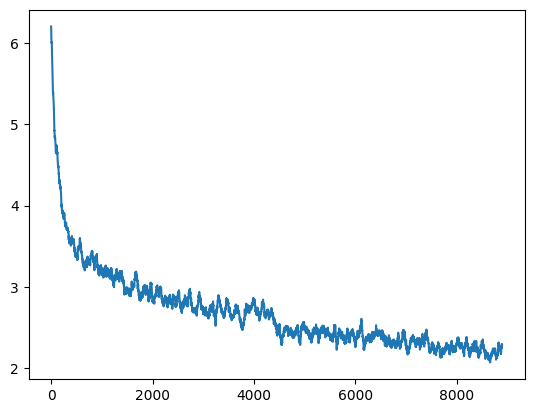

In [29]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [30]:
# Cell 30 - Correct input_ids device placement based on model's device
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text=test_sentence,
    target_lang='ja',
    tokenizer=tokenizer,
    seq_len=model.config.max_length,
    lang_token_map=LANG_TOKEN_MAPPING
)
# Move input_ids to the same device as the model
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [31]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

ランドウィック・レースコーストで8名のハイブリッド・レース・カーは
ランドウィック・レースコーストで8名のハイブリット・レース・カーは
ランドウィック・レースコーストで8名のハイブリッド・レースカーは、


In [61]:
#@title Slick Blue Translate
input_text = 'what is your name ?' #@param {type:"string"}
output_language = 'zh' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

what is your name ?  ->  你的名字是什么?


In [99]:
import torch
torch.cuda.empty_cache()

In [33]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [100]:
%%writefile app1_en_to_ja.py
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Supported translation models
LANGUAGES = {

    "English to French": "Helsinki-NLP/opus-mt-en-fr",
    "English to German": "Helsinki-NLP/opus-mt-en-de",
    "English to Spanish": "Helsinki-NLP/opus-mt-en-es",
    "French to English": "Helsinki-NLP/opus-mt-fr-en",
    "German to English": "Helsinki-NLP/opus-mt-de-en",
    "Spanish to English": "Helsinki-NLP/opus-mt-es-en",

}

# Load model and tokenizer for the selected language pair
@st.cache_resource
def load_model(model_repo):
    tokenizer = AutoTokenizer.from_pretrained(model_repo)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
    if torch.cuda.is_available():
        model = model.cuda()
    return tokenizer, model

# Streamlit UI
st.title("Multi-Language Translation App")

# Language selection
selected_translation = st.selectbox("Select translation pair:", list(LANGUAGES.keys()))
model_repo = LANGUAGES[selected_translation]
tokenizer, model = load_model(model_repo)

input_text = st.text_area("Enter text to translate:", "Hello, how are you?")

if st.button("Translate"):
    with st.spinner("Translating..."):
        input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512)
        input_ids = input_ids.cuda() if torch.cuda.is_available() else input_ids
        output_tokens = model.generate(input_ids, num_beams=5, length_penalty=1.0, max_length=100)
        translated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
        st.write(f"**Translated Text ({selected_translation.split(' to ')[1]}):** {translated_text}")




Overwriting app1_en_to_ja.py


In [102]:
from pyngrok import ngrok

# Start Streamlit and connect to ngrok
!streamlit run app1_en_to_ja.py --server.port 8502 &>/dev/null &
public_url = ngrok.connect(8502, proto="http")
print(f"Public URL: {public_url}")


# ... keep the script running to maintain the tunnel ...

Public URL: NgrokTunnel: "https://017c-34-142-169-3.ngrok-free.app" -> "http://localhost:8502"


In [101]:
from pyngrok import ngrok

ngrok.kill()

[link text](https://)